In [1]:
%load_ext autoreload
%autoreload 2

In [139]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from collections import Counter

# NLP and Text Processing
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import cmudict
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Scikit-learn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report

# Local
from classes.song import Song
from classes.spotify_manager import SpotifyManager
from classes.lyrics_manager import LyricsManager
from classes.utils import gather_data_from_folders, variance_based_empath_cleaning
from classes.stats import BootstrapEvaluator
from classes.model_pipeline import OptimalClassificationPipeline, OptimalRegressionPipeline

import warnings
from empath import Empath
warnings.simplefilter('ignore')
load_dotenv();

# Loading the data

In [46]:
df = pd.read_pickle(os.path.join('datasets', "final_data.pkl"))
print(f"Loaded {df.shape[0]} songs")
df.head()

Loaded 5387 songs


,id,title,artist,album_art_url,popularity,explicit,album_release_year,duration_ms,genres,lyrics,...,dale_chall,vader_compound,noun_ratio,verb_ratio,language,sentiment_polarity,sentiment_subjectivity,type_token_ratio,repetition_count,preprocessed_lyrics
0,4RL77hMWUq35NYnPLXBpih,skinny love,birdy,https://i.scdn.co/image/ab67616d0000b2733661c0...,70.0,0,2011,201080,"['neo mellow', 'uk pop', 'viral pop']",come skinni love last year pour littl salt nev...,...,10.78,0.9738,0.506173,0.246914,english,0.276623,0.670563,0.691358,25,come skinni love last year pour littl salt nev...
1,5PsjZ21f5tMPFf1sJpokm7,deathwish,red sun rising,https://i.scdn.co/image/ab67616d0000b273612f16...,NaN,0,2018,287946,"['modern hard rock', 'post-grunge']",life fleet slow chill us wave feed bone right ...,...,10.55,0.9758,0.340426,0.191489,english,0.128397,0.563763,0.260638,139,life fleet slow chill us wave feed bone right ...
2,6vrUTGn5p8IrfTZ0J6sIVM,iris,the goo goo dolls,https://i.scdn.co/image/ab67616d0000b273d54c4b...,71.0,0,2007,289906,"['neo mellow', 'permanent wave', 'pop rock', '...",id give forev touch caus know feel somehow you...,...,11.16,-0.8865,0.390476,0.323810,english,-0.259184,0.447959,0.428571,60,id give forev touch caus know feel somehow clo...
3,0Leo4GP0UKG4tUABm9JATe,don't dream it's over,crowded house,https://i.scdn.co/image/ab67616d0000b27380ed24...,NaN,0,2017,231377,"['australian rock', 'permanent wave']",freedom within freedom without tri catch delug...,...,12.27,-0.9549,0.460317,0.277778,english,0.581746,0.379894,0.484127,65,freedom within freedom without tri catch delug...
4,0It6VJoMAare1zdV2wxqZq,undisclosed desires,muse,https://i.scdn.co/image/ab67616d0000b273b6d456...,65.0,0,2009,235000,"['alternative rock', 'modern rock', 'permanent...",know youv suffer dont want hide cold loveless ...,...,11.77,0.4822,0.448276,0.252874,english,-0.162245,0.591270,0.494253,44,know youv suffer dont want hide cold loveless ...


In [47]:
df['popularity_imputed'] = 0
df.loc[df.popularity.isna(), 'popularity_imputed'] = 1
df.loc[df.popularity.isna(), 'popularity']  = df[~df.popularity.isna()].popularity.median()

In [48]:
df.popularity_imputed.value_counts()

popularity_imputed
0    4856
1     531
Name: count, dtype: int64

In [49]:
from classes.word_embeddings import TfidfFeatureExtractor, Word2VecFeatureExtractor
from classes.text_features import TextFeatureExtractor

In [50]:
te = TextFeatureExtractor()
df = te.add_features(df)

Processing Features:   0%|          | 0/5387 [00:00<?, ?it/s]

ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'indonesian' is not supported.
ERROR:root:Error processing row: The language 'turkish' is not supported.
ERROR:root:Error processing row: The language 'catalan' is not supported.
ERROR

In [51]:
tfe = TfidfFeatureExtractor(n_pca_components=100)
df = tfe.add_features(df)

In [52]:
w2v = Word2VecFeatureExtractor(n_pca_components=100)
df = w2v.add_features(df)

Extracting Word2Vec Features:   0%|          | 0/5387 [00:00<?, ?it/s]

In [53]:
df.shape

(5387, 474)

In [54]:
spotify_features = ['popularity', 'explicit',
       'album_release_year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature']

lyrics_features = ['unique_word_count',
       'sentiment_polarity', 'sentiment_subjectivity', 'noun_ratio',
       'verb_ratio', 'vader_compound', 'repetition_count', 'language', 'genre',
       'lexical_richness', 'semantic_depth', 'syntactic_complexity',
       'rhyme_density', 'sentiment_variability', 'linguistic_uniqueness',
       'flesch_reading_ease', 'gunning_fog', 'dale_chall', 'type_token_ratio', 'word_count']

tfidf_features = [ f for f in df.columns if f.startswith("tfidf_") ]

w2v_features = [ f for f in df.columns if f.startswith("w2v") ]

empath_features = [ f for f in df.columns if f.startswith("empath") ]

audio_extracted_features = ['mfcc_1', 'mfcc_2',
       'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8',
       'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'spectral_contrast_1', 'spectral_contrast_2', 'spectral_contrast_3',
       'spectral_contrast_4', 'spectral_contrast_5', 'spectral_contrast_6',
       'spectral_contrast_7', 'tempo_extracted', 'zcr']

In [141]:
empath_features = variance_based_empath_cleaning(df)

INFO: Total empath features: 194
INFO: Low-variance features to remove: 117


# 1. EDA

## 1. Correlation Heatmap


In [142]:
def correlation_heatmap(df: pd.DataFrame, features: List[str], title: str = 'Heatmap of Top Correlated Features', threshold: float = 0.6):
    num_df = df[features].dropna().select_dtypes(include=[np.number])
    
    corr_matrix = num_df.corr()
    
    high_corr_features = corr_matrix[corr_matrix.abs() > threshold].stack().reset_index()
    high_corr_features = high_corr_features[high_corr_features['level_0'] != high_corr_features['level_1']]
    
    top_corr_features = pd.unique(high_corr_features[['level_0', 'level_1']].values.ravel('K'))
    
    plt.figure(figsize=(20, 15))
    sns.heatmap(num_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    if title:
        plt.title(title)
    else:
        plt.title('Heatmap of Top Correlated Features', fontsize=12)
    plt.show()

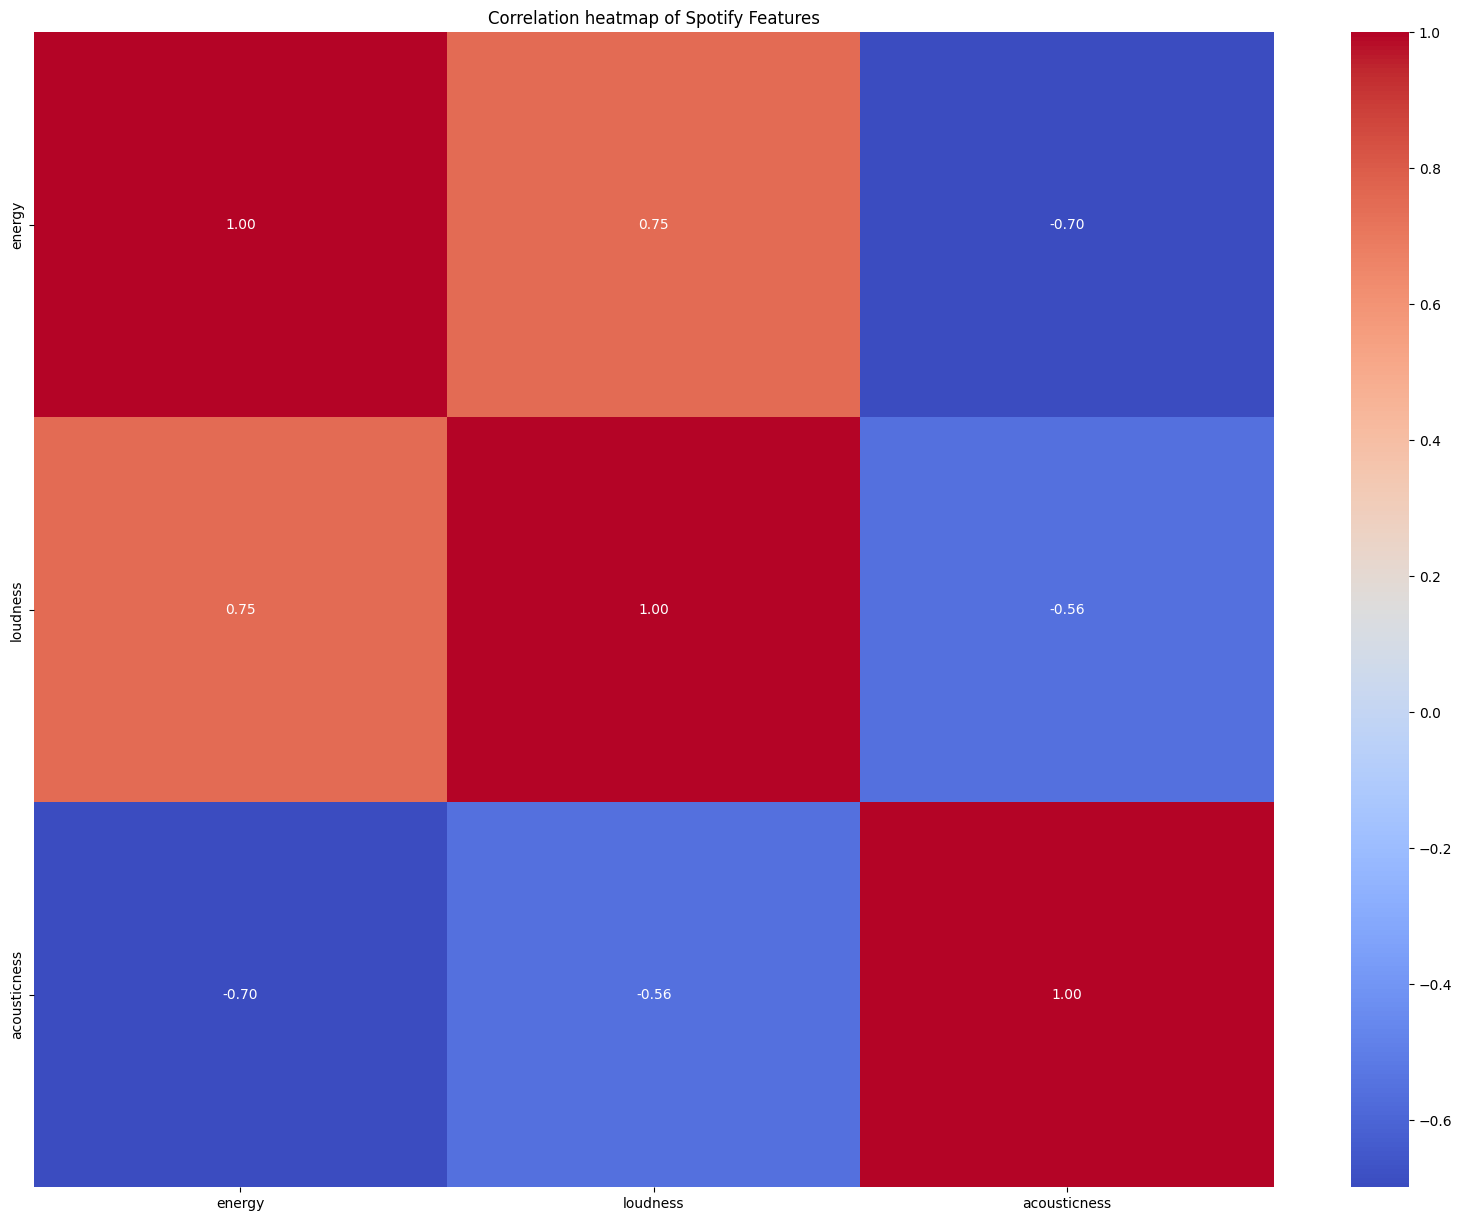

In [144]:
correlation_heatmap(df, spotify_features, title='Correlation heatmap of Spotify Features')

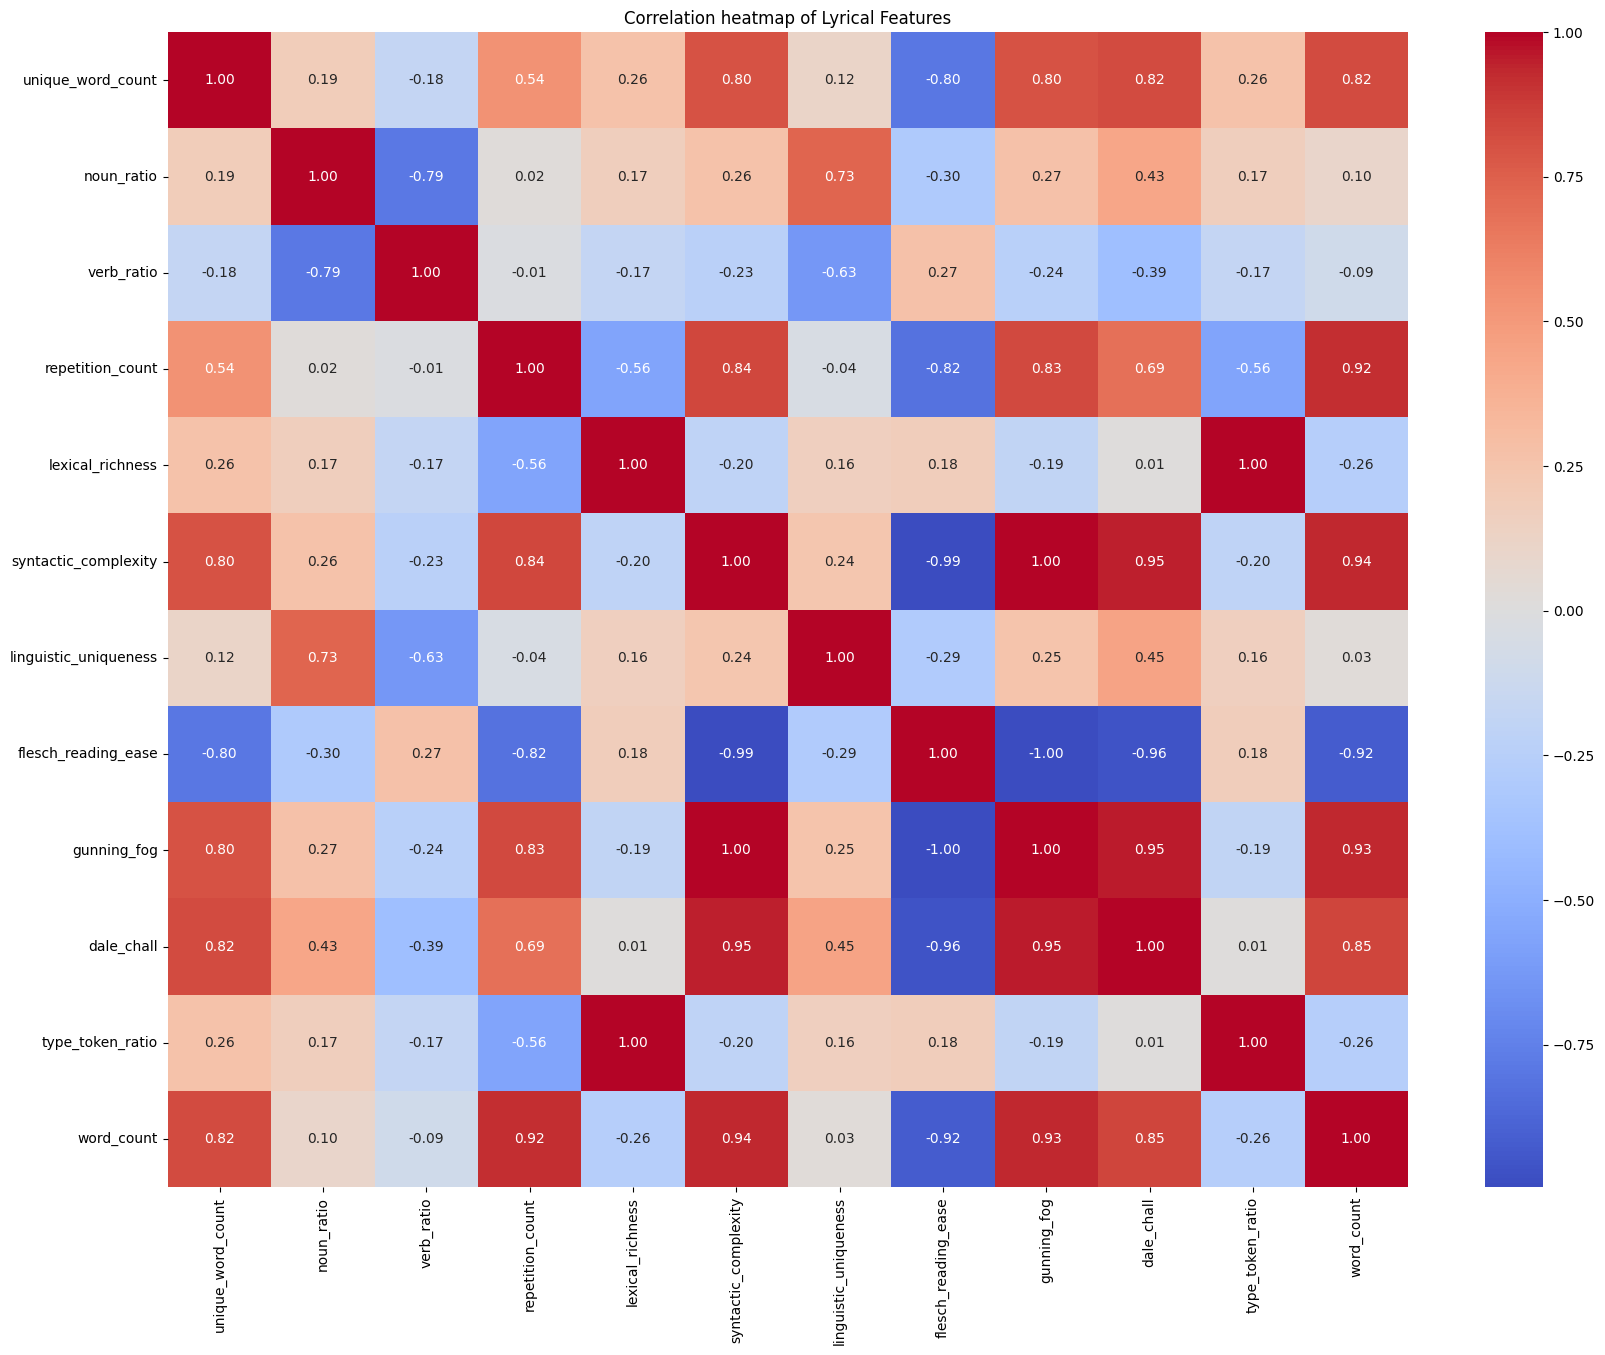

In [145]:
correlation_heatmap(df, lyrics_features, title='Correlation heatmap of Lyrical Features')

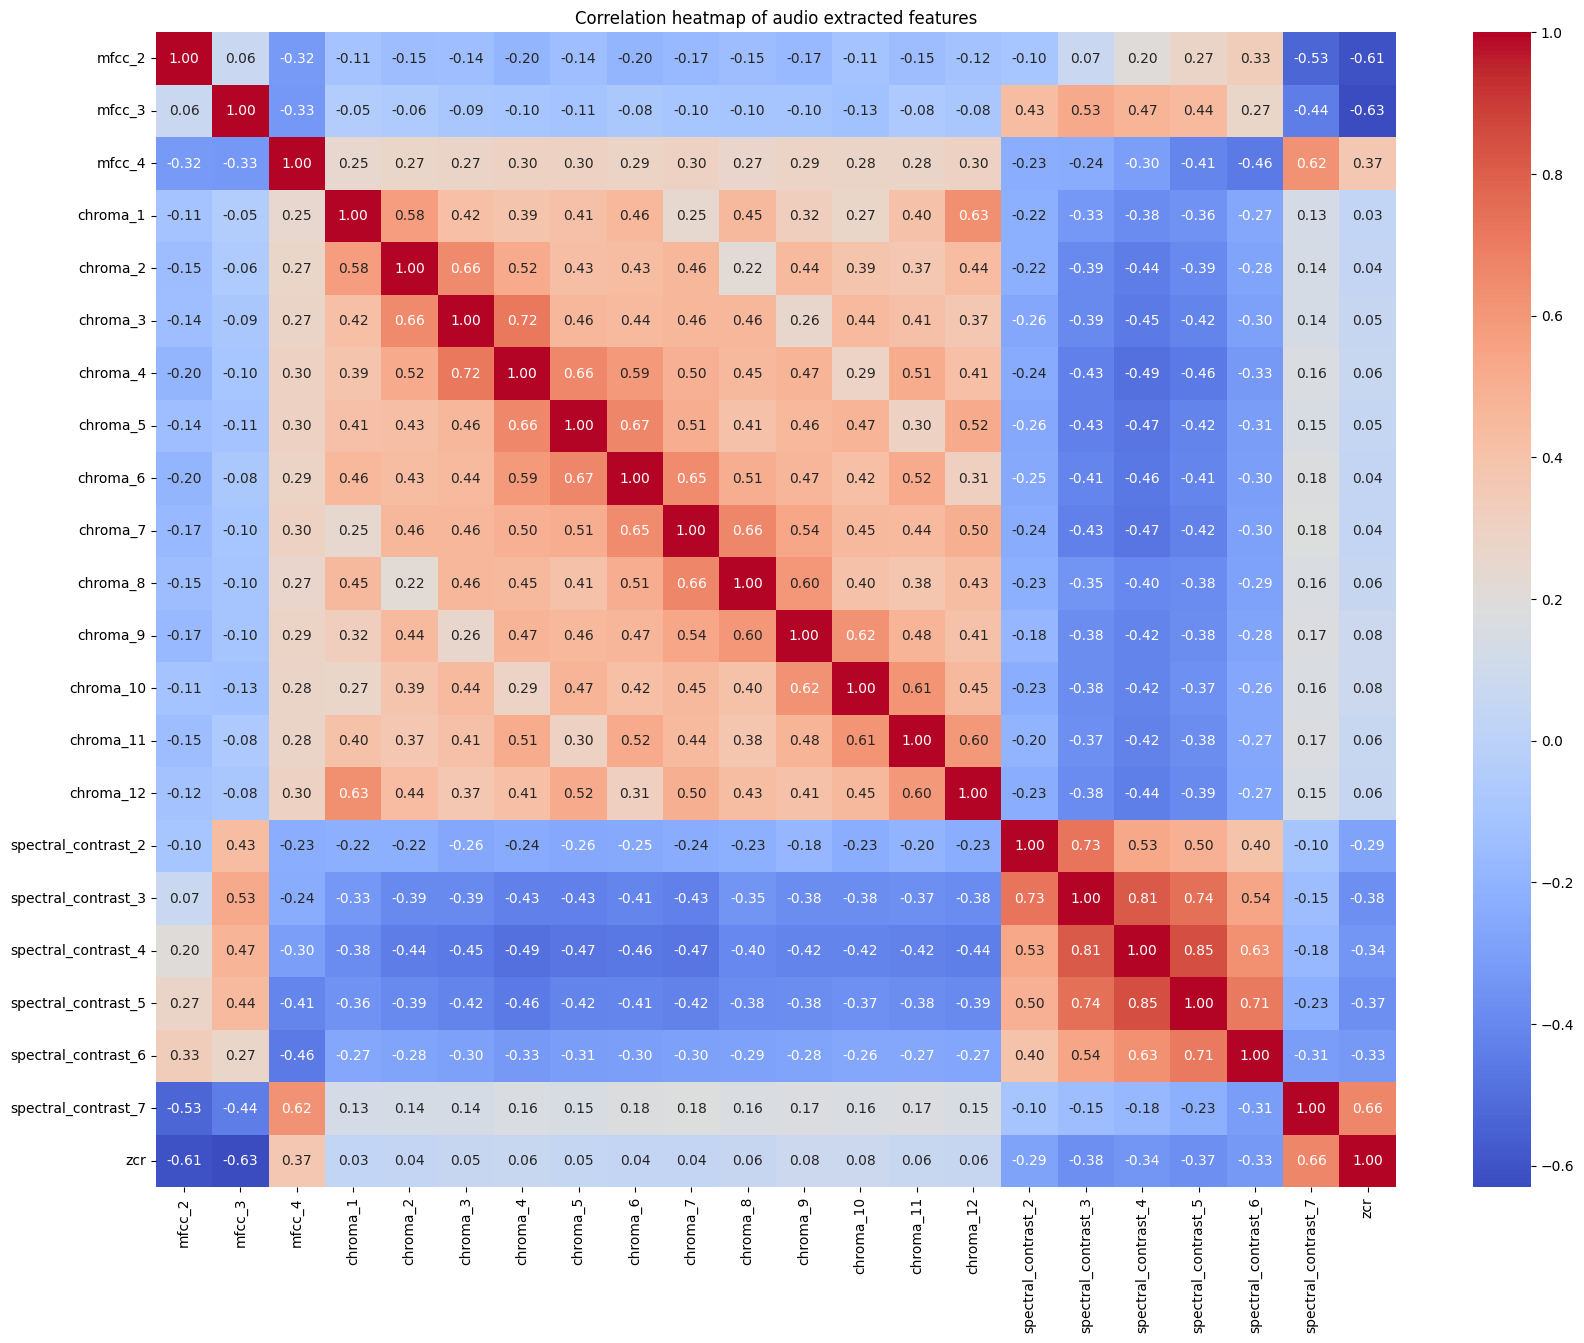

In [146]:
correlation_heatmap(df, audio_extracted_features, title='Correlation heatmap of audio extracted features')

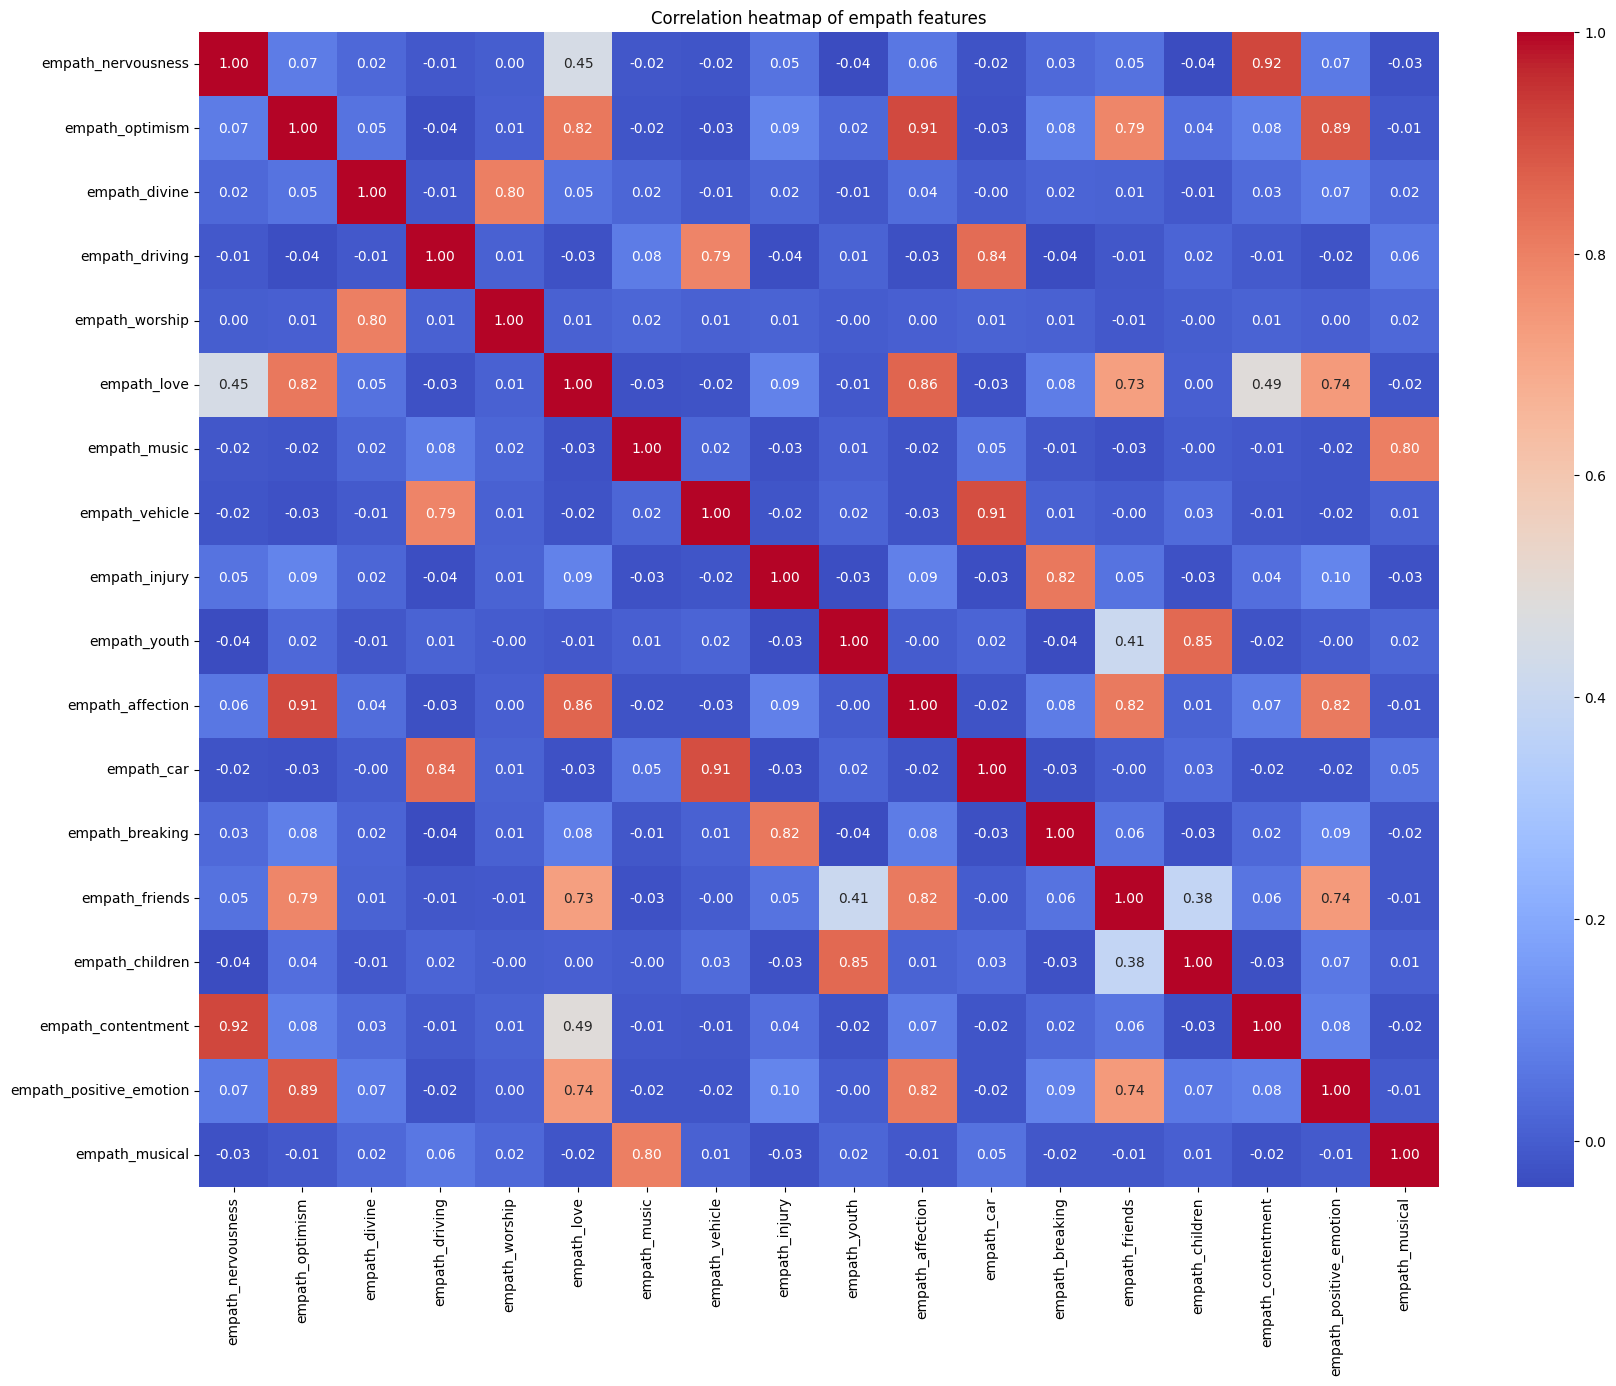

In [148]:
correlation_heatmap(df, empath_features, title='Correlation heatmap of empath features', threshold=0.8)

## 2. Hierarchical Clustering (Dendrogram)
Purpose:
Hierarchical clustering groups similar features based on their pairwise correlations, visualized using a dendrogram. This technique helps in clustering features into groups that are highly correlated, reducing dimensionality or simplifying feature analysis.

How It Works:

The dendrogram is built using agglomerative clustering, where each feature starts in its own cluster, and the most similar clusters are merged at each step. This continues until all features are grouped into a single cluster.
The Ward linkage method was used, which minimizes the variance within clusters.
The vertical axis represents the distance (or dissimilarity) between clusters. The longer the vertical lines between two clusters, the more dissimilar they are.
Conclusion:
Hierarchical clustering allowed you to identify clusters of features that are strongly correlated. You can decide to keep one feature from each cluster to avoid redundancy. For example, acousticness and instrumentalness might fall into the same cluster due to their similarity.

In [149]:
from typing import List
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

def plot_dendrogram(df: pd.DataFrame, features: List[str], title: str = "Features"):
    num_df = df[features].dropna().select_dtypes(include=[np.number])
    
    corr_matrix = num_df.corr()
    
    distance_matrix = 1 - corr_matrix.abs()
    
    distance_matrix = distance_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    condensed_distance = distance_matrix.values[np.triu_indices_from(distance_matrix, k=1)]
    
    linked = linkage(condensed_distance, method='ward')
    
    plt.figure(figsize=(15, 10))
    dendrogram(linked, labels=corr_matrix.columns, orientation='right', distance_sort='descending')
    plt.title(f'Hierarchical Clustering Dendrogram of {title}', fontsize=16)
    plt.show()

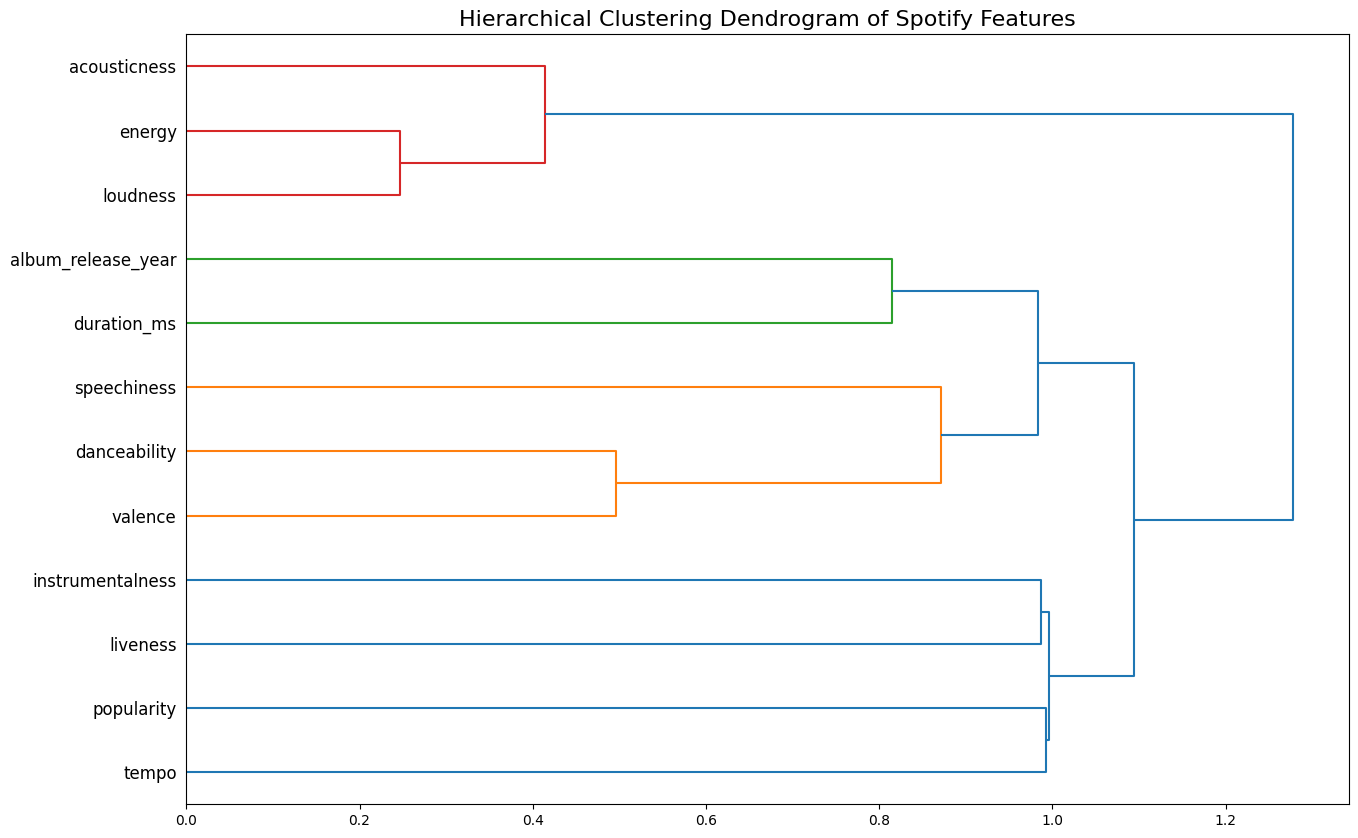

In [134]:
plot_dendrogram(df, spotify_features, title='Spotify Features')

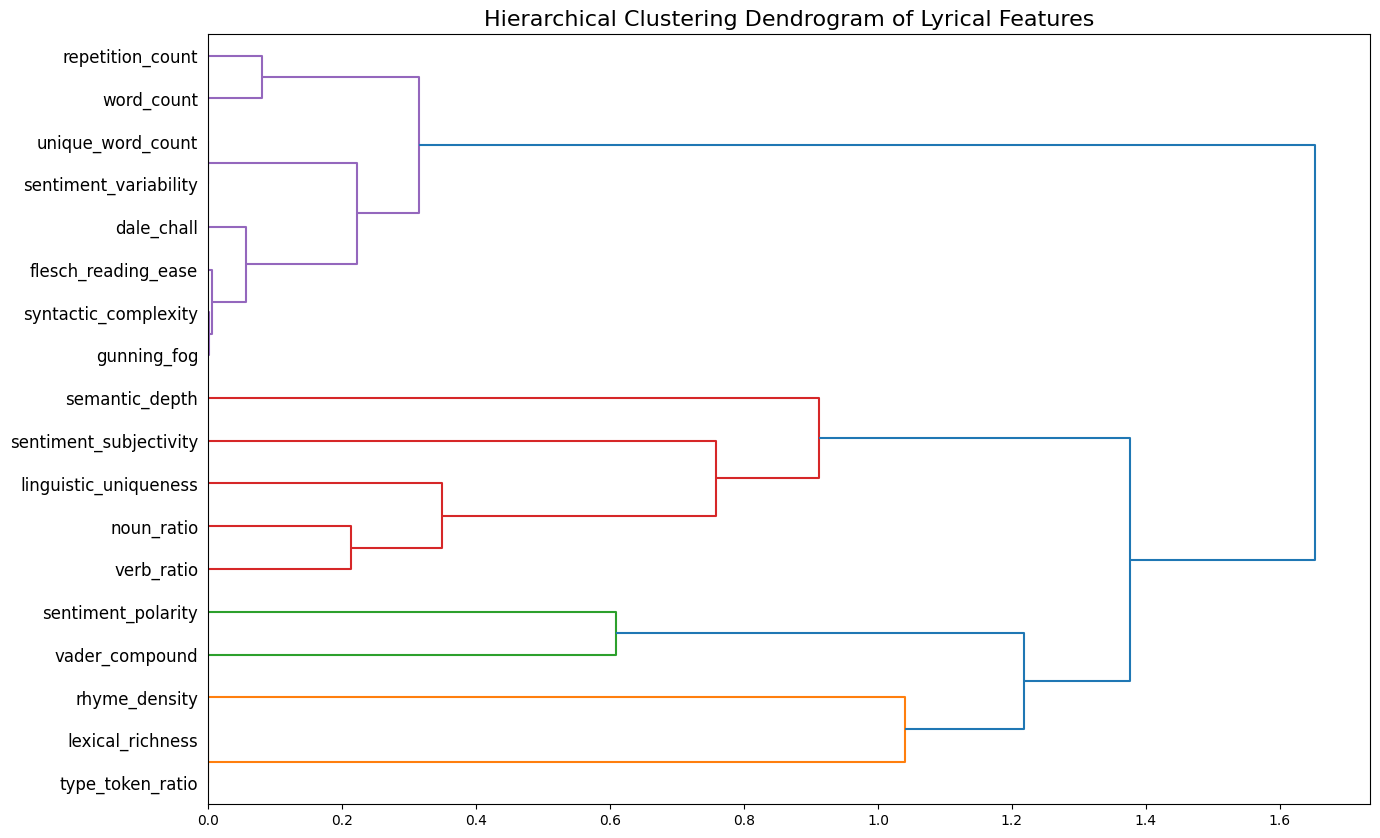

In [136]:
plot_dendrogram(df, lyrics_features, title='Lyrical Features')

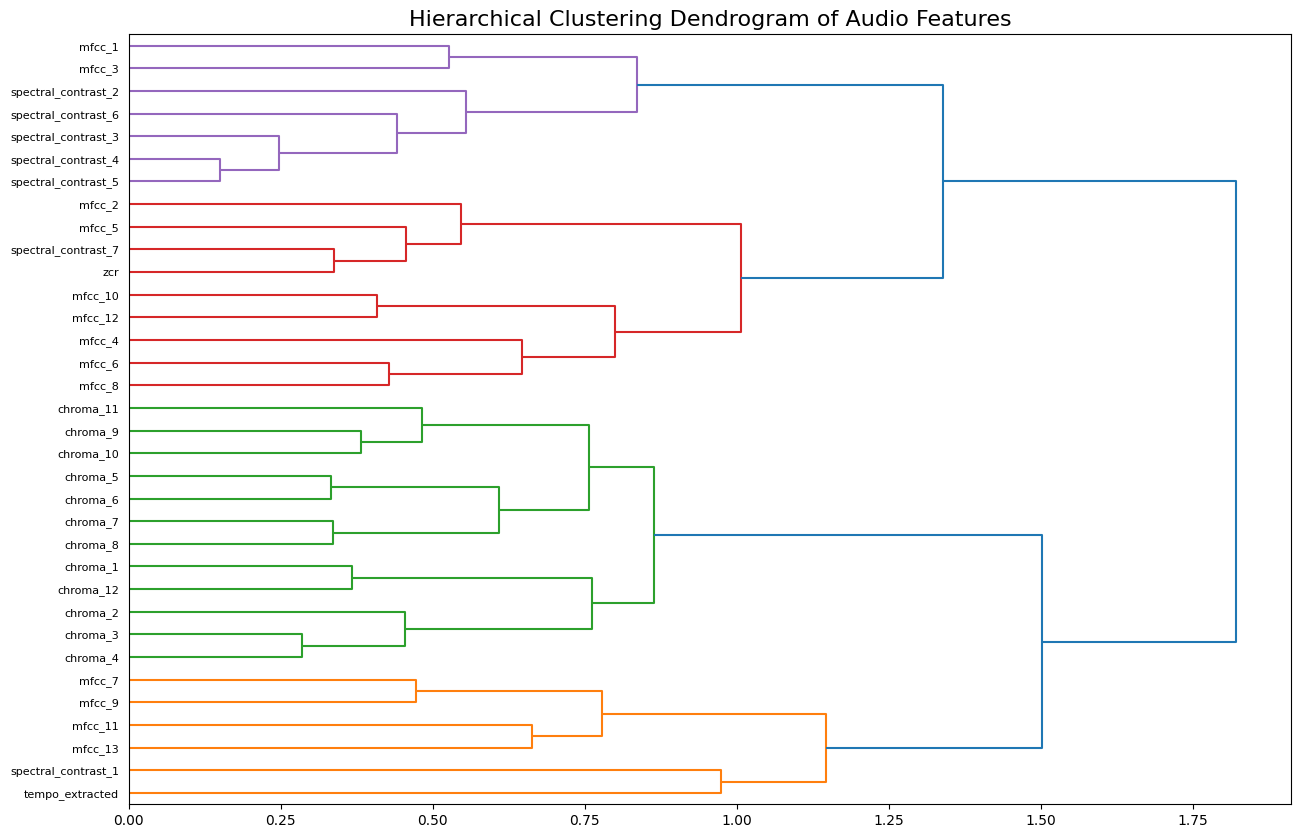

In [137]:
plot_dendrogram(df, audio_extracted_features, title='Audio Features')

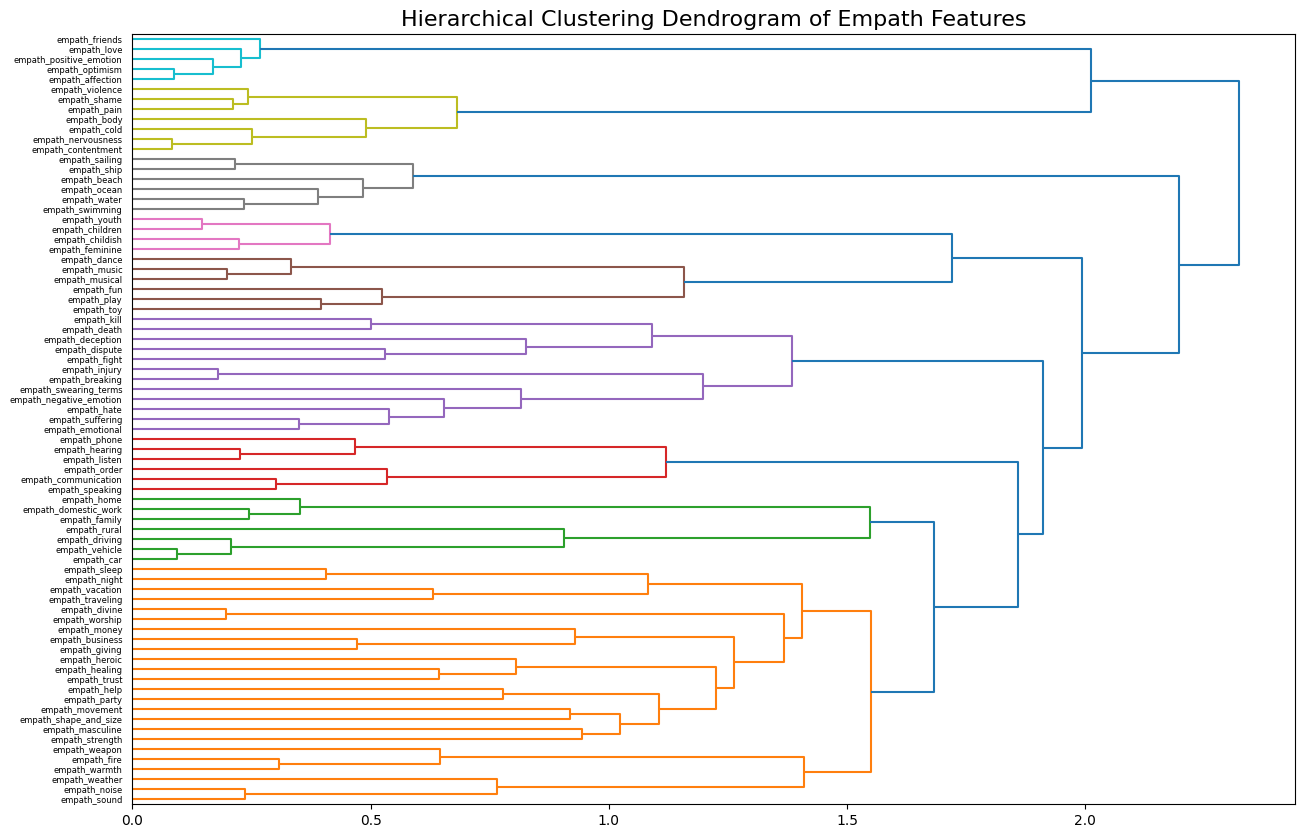

In [138]:
plot_dendrogram(df, empath_features, title='Empath Features')

## 4. Network Graph of Highly Correlated Features
Purpose:
This method visualizes the relationships between highly correlated features as a network graph. It helps in understanding how features are interconnected.

How It Works:

You constructed a graph where each node represents a feature, and edges between nodes represent strong correlations (above a threshold, e.g., 0.7).
The spring layout was used to visualize the network, where highly connected nodes are pulled together, and less connected nodes are pushed apart.
Conclusion:
The network graph gives a visual summary of how features relate to each other, with clusters of nodes indicating groups of correlated features. This helps identify which features tend to co-occur in specific types of songs, such as danceability and energy forming one group, and acousticness and instrumentalness forming another.

In [154]:
import networkx as nx

def plot_network(df: pd.DataFrame, features: List[str], title: str = "Features", threshold: float = 0.4):
    num_df = df[features].dropna().select_dtypes(include=[np.number])
    corr_matrix = num_df.corr().abs()
    high_corr_pairs = corr_matrix.unstack().reset_index()
    high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
    high_corr_pairs = high_corr_pairs[(high_corr_pairs['Correlation'] > threshold) & (high_corr_pairs['Feature1'] != high_corr_pairs['Feature2'])]
    
    G = nx.from_pandas_edgelist(high_corr_pairs, 'Feature1', 'Feature2', edge_attr='Correlation')
    
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.15)
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', font_size=10)
    plt.title(f'Network Graph of Highly Correlated {title}', fontsize=16)
    plt.show()


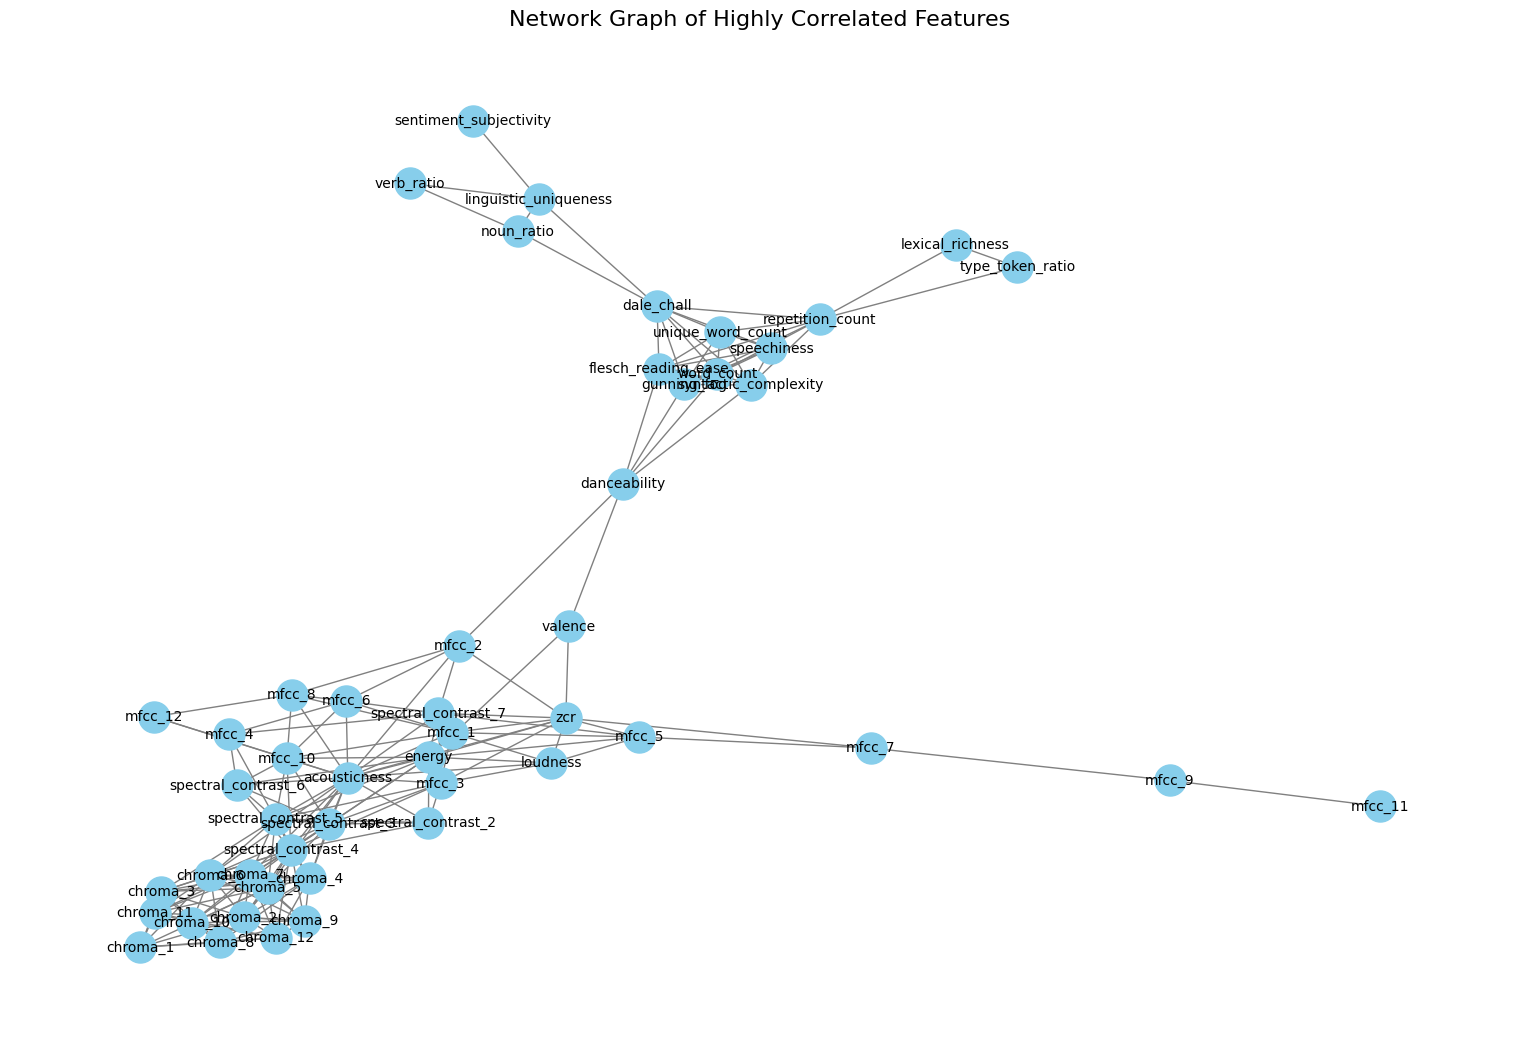

In [155]:
plot_network(df, lyrics_features + spotify_features + audio_extracted_features)

## 5. t-SNE (t-Distributed Stochastic Neighbor Embedding)
Purpose:
t-SNE is used to visualize high-dimensional data in a 2D or 3D space while preserving local structure (similarities between points). It is particularly useful for visualizing clusters in data.

How It Works:

t-SNE reduces the dimensionality of data by modeling pairwise similarities between points in high-dimensional space and attempts to preserve these similarities in the low-dimensional projection.
t-SNE uses a probability distribution to calculate the similarity between points, with closer points in the original space being more likely to remain close in the reduced space.
It is useful for visualizing non-linear relationships in data, unlike PCA, which focuses on linear variance.
Conclusion:
In your t-SNE plot, you likely saw clusters of points corresponding to groups of songs that are similar in terms of their features. Well-separated clusters suggest that the songs in different groups are quite distinct in terms of musical characteristics or lyrics.



In [160]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Optional

def plot_tsne(df: pd.DataFrame, features: List[str], hue: Optional[str] = None, title: str = "Feature"):
    """
    Plots a t-SNE visualization of numerical features with an optional hue for coloring.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        features (List[str]): List of numerical features to include in t-SNE.
        hue (Optional[str]): Column name to use for coloring the scatterplot (e.g., 'genre').
        title (str): Title for the plot.
    """
    # Ensure only numerical features and drop NaNs
    num_df = df[features].dropna().select_dtypes(include=[np.number])

    # Align hue column with filtered data
    if hue:
        hue_values = df.loc[num_df.index, hue]
    else:
        hue_values = None

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(num_df)

    # Create a DataFrame for the t-SNE result
    tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
    if hue:
        tsne_df['Hue'] = hue_values.reset_index(drop=True)

    # Plot with hue if provided
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        x='Component 1', 
        y='Component 2', 
        hue='Hue' if hue else None, 
        data=tsne_df, 
        # palette='viridis', 
        alpha=0.7
    )
    plt.title(f't-SNE Visualization of {title} Relationships', fontsize=16)
    plt.show()


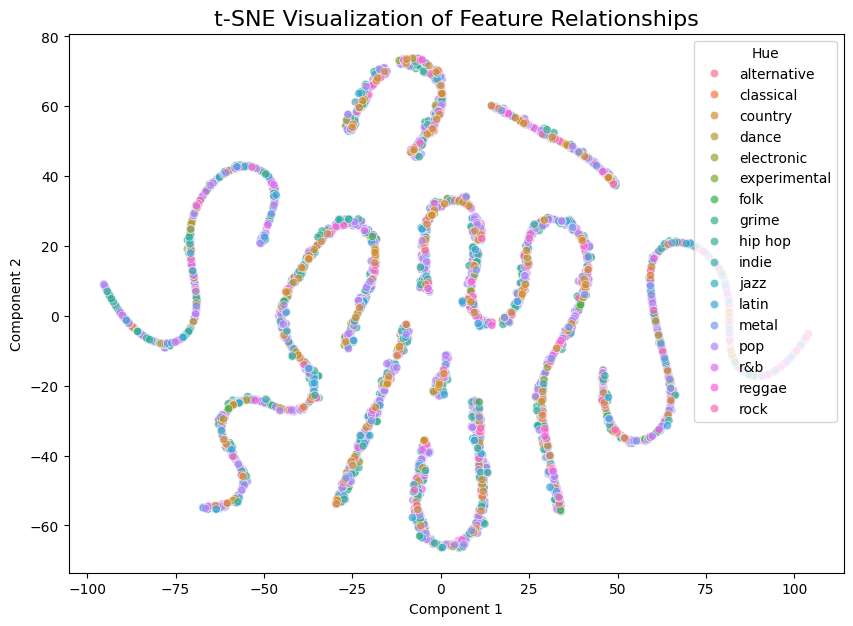

In [161]:
plot_tsne(df, lyrics_features + audio_extracted_features + tfidf_features + spotify_features + w2v_features + empath_features, hue='genre')

# Genres EDA

In [162]:
num_df = df[lyrics_features + audio_extracted_features + tfidf_features + spotify_features + w2v_features + empath_features].dropna().select_dtypes(include=[np.number])
num_df = pd.concat([num_df, df.genre], axis=1)
genre_features = num_df.groupby("genre").mean()

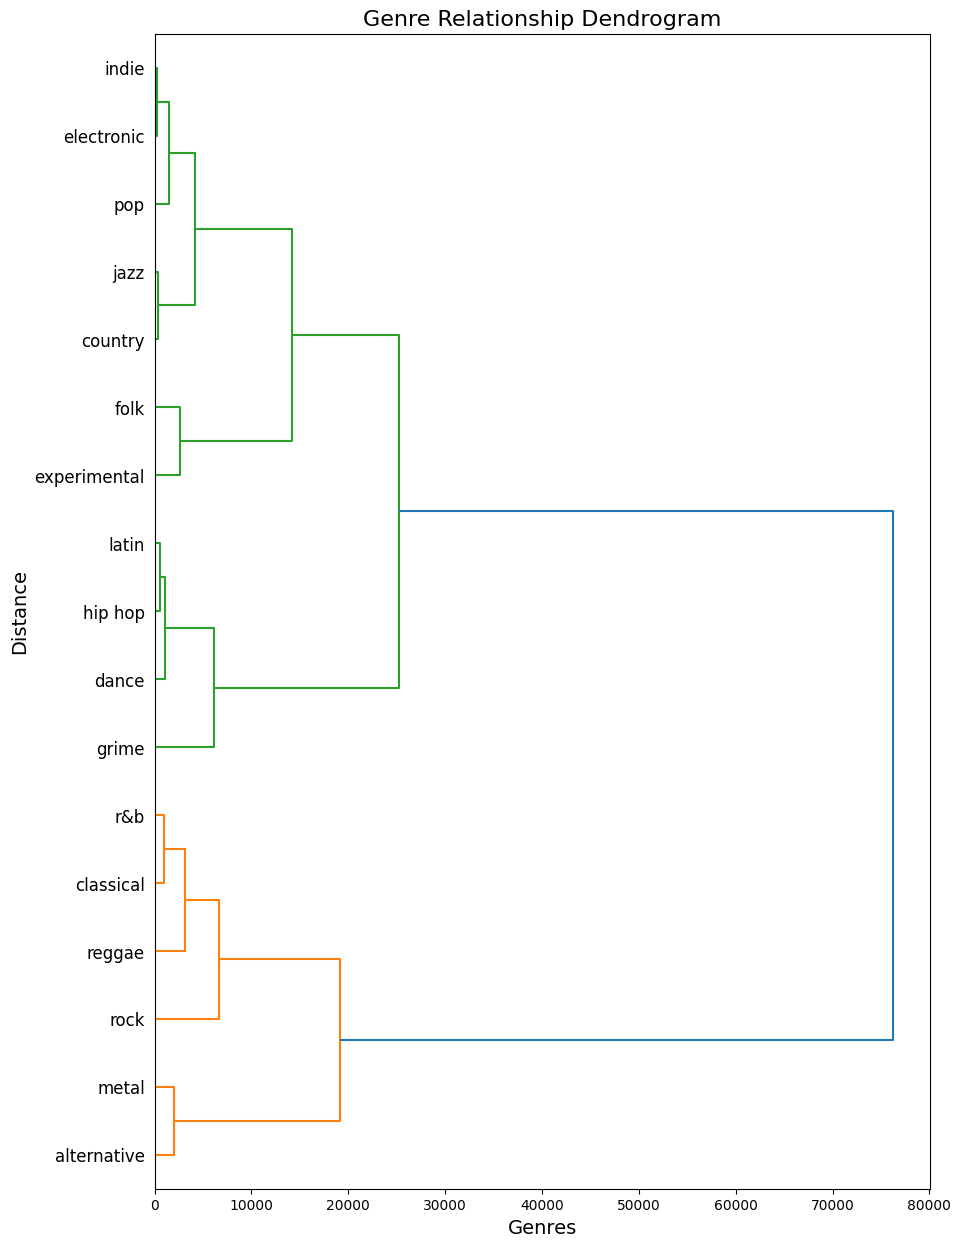

In [163]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform hierarchical clustering
linkage_matrix = linkage(genre_features, method='ward')

# Create a wider plot
plt.figure(figsize=(10, 15))  # Adjust width and height
dendrogram(linkage_matrix, labels=genre_features.index,orientation='right')
plt.title("Genre Relationship Dendrogram", fontsize=16)
plt.xlabel("Genres", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()


<Axes: >

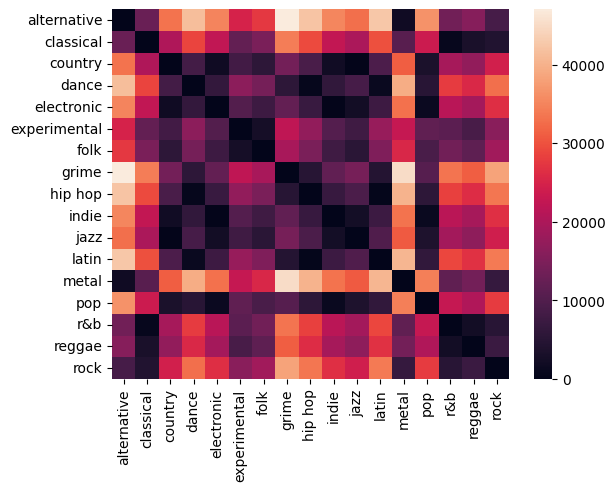

In [164]:
from scipy.spatial.distance import pdist, squareform
distance_matrix = squareform(pdist(genre_features, metric='euclidean'))
sns.heatmap(distance_matrix, xticklabels=genre_features.index, yticklabels=genre_features.index)#, cmap="viridis")